In [2]:
!pip install transformers==2.8.0

     |████████████████████████████████| 563 kB 5.4 MB/s 
     |████████████████████████████████| 895 kB 51.5 MB/s 
     |████████████████████████████████| 5.6 MB 22.5 MB/s 
     |████████████████████████████████| 1.2 MB 50.4 MB/s 
     |████████████████████████████████| 131 kB 43.8 MB/s 
     |████████████████████████████████| 8.5 MB 53.2 MB/s 
     |████████████████████████████████| 79 kB 6.2 MB/s 
     |████████████████████████████████| 138 kB 52.8 MB/s 
     |████████████████████████████████| 127 kB 73.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [3]:
import os
import json
import time
import torch
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from torch.utils.data import TensorDataset, random_split, \
                            DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertForSequenceClassification, CamembertTokenizer, \
                         AdamW, get_linear_schedule_with_warmup

# Functions : preprocess() (create dataloaders from raw data) 
# load_models() (load tokenizers and models) training() (loop of one training step) evaluate()

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
dataset = pd.read_csv("""/content/gdrive/My Drive/lemonde.csv""",sep=";")
dataset.head()
#dataset=dataset.sample(n=10000)

,url,titre,chapo,categorie,date
0,https://www.lemonde.fr/europe/article/2015/01/...,La marine italienne prend le contrôle d'un bat...,Le navire a été abandonné par son équipage alo...,europe,01-01-2015
1,https://www.lemonde.fr/football/article/2015/0...,Foot anglais : Chelsea explose et se fait rejo...,Après l'explosion en vol des Blues à Tottenham...,football,01-01-2015
2,https://www.lemonde.fr/asie-pacifique/article/...,La Corée du Nord ouvre timidement son économie,La dictature asiatique tente de sortir de son ...,asie-pacifique,01-01-2015
3,https://www.lemonde.fr/economie/article/2015/0...,L’Etat paie au prix fort son revirement sur l’...,"L’abandon de ce dispositif, déjà installé, de ...",economie,01-01-2015
4,https://www.lemonde.fr/europe/article/2015/01/...,Suède : une troisième mosquée attaquée en huit...,Le premier ministre suédois a affirmé que le g...,europe,01-01-2015


In [6]:
len(dataset)

131305

In [7]:
#Categories selection
dataset.loc[(dataset.categorie== 'ameriques')|(dataset.categorie=="europe" )|(dataset.categorie==  'international')|(dataset.categorie=='afrique')|(dataset.categorie== 'asie-pacifique')| (dataset.categorie== 'proche-orient'),"categorie"]="international"
dataset.loc[(dataset.categorie=="arts")|(dataset.categorie=='festival')|(dataset.categorie=='musiques')|(dataset.categorie=='cinema')|(dataset.categorie=='televisions-radio')|(dataset.categorie=='culture')|(dataset.categorie=='livres'),"categorie"]="culture"
dataset.loc[(dataset.categorie=="entreprises")|(dataset.categorie=="economie")|(dataset.categorie=="argent")|(dataset.categorie=="emploi"),"categorie"]="economie"
#dataset.loc[(dataset.categorie=="football")|(dataset.categorie=="sport"),"categorie"]="sport"
#dataset.loc[(dataset.categorie=="sciences")|(dataset.categorie=="sante"),"categorie"]="santé/science"
dataset.loc[(dataset.categorie=="police-justice")|(dataset.categorie=="idees")|(dataset.categorie=="societe")|(dataset.categorie=="politique"),"categorie"]="politique/société"
dataset.loc[(dataset.categorie=="planete")|(dataset.categorie=="pixels"),"categorie"]="numérique/environnement"

In [8]:
dataset = dataset[dataset.categorie.isin(["international","culture","economie",
                                         "numérique/environnement","politique/société"])]
dataset.reset_index(drop=True,inplace=True)
dataset.categorie = dataset.categorie.map({"international":0,"culture":1,"economie":2,
                                         "numérique/environnement":3,"politique/société":4})

In [9]:
dataset.categorie.value_counts()

0    33558
4    26791
2    15361
1    14191
3    10253
Name: categorie, dtype: int64

### Manual undersampling

In [10]:
d1 = dataset[dataset["categorie"]==0].sample(n=1000,random_state=42)
d2 = dataset[dataset["categorie"]==1].sample(n=1000,random_state=42)
d3 = dataset[dataset["categorie"]==2].sample(n=1000,random_state=42)
d4 = dataset[dataset["categorie"]==3].sample(n=1000,random_state=42)
d5 = dataset[dataset["categorie"]==4].sample(n=1000,random_state=42)

dataset = pd.concat([d1,d2,d3,d4,d5])


In [11]:
dataset.categorie.value_counts()

3    1000
2    1000
1    1000
4    1000
0    1000
Name: categorie, dtype: int64

In [12]:
dataset = dataset.sample(frac = 1,random_state=42)
dataset.reset_index(drop=True,inplace=True)
dataset.head()

,url,titre,chapo,categorie,date
0,https://www.lemonde.fr/culture/article/2019/12...,"Milan Kundera, la nostalgie de Prague","Kundera, le roman d’une vie (6/6). « La France...",1,21-12-2019
1,https://www.lemonde.fr/argent/article/2018/08/...,"Sur la Côte d’Azur, des galeries hors des sent...","Les galeries Chave, à Vence, et Catherine Isse...",2,12-08-2018
2,https://www.lemonde.fr/economie/article/2020/0...,"Le secteur parapétrolier, épine dans le pied d...",La banque publique d’investissement détient to...,2,24-07-2020
3,https://www.lemonde.fr/cinema/article/2016/01/...,« Koan de printemps » : passion asiatique et p...,"Fable située dans le Vietnam ancestral, le pre...",1,24-01-2016
4,https://www.lemonde.fr/afrique/article/2020/02...,« Nous avons quelques semaines pour contrôler ...,Un expert de la FAO presse la communauté inter...,0,07-02-2020


In [13]:
dataset["reviews"] = dataset['chapo'] + dataset['titre']
reviews = dataset["reviews"].values.tolist()
sentiments = dataset['categorie'].values.tolist()

TOKENIZER = CamembertTokenizer.from_pretrained(
    'camembert-base',
    do_lower_case=True)

Downloading:   0%|          | 0.00/811k [00:00<?, ?B/s]

In [14]:
def preprocess(raw_reviews, sentiments=None):
    """
    Cette fonction prends de la donnée brute en argument et retourne un 'dataloader' pytorch

    Args
        raw_reviews (array-like) : Une liste de reviews sous forme de 'str'
        
        sentiments : Une liste 'sentiments' (0 = negatif, 1 = positif) de la meme taille que
                     'raw_review'
    
    Returns
        inputs_ids, attention_masks, sentiments(optionel) : Objet  de PyTorch qui contient 
                    les versions tokenisees et encodees des donnees brutes
    """

    
    #device = torch.device("cpu")

    encoded_batch = TOKENIZER.batch_encode_plus(raw_reviews,
                                                add_special_tokens=False,
                                                pad_to_max_length=True,
                                                return_attention_mask=True,
                                                return_tensors = 'pt')
    if sentiments:
        sentiments = torch.tensor(sentiments)
        return encoded_batch['input_ids'].to(device), encoded_batch['attention_mask'].to(device), sentiments.to(device)
    return encoded_batch['input_ids'].to(device), encoded_batch['attention_mask'].to(device)

In [15]:
def preprocess(raw_reviews, sentiments=None):


    

    encoded_batch = TOKENIZER.batch_encode_plus(raw_reviews,
                                                add_special_tokens=False,
                                                pad_to_max_length=True,
                                                return_attention_mask=True,
                                                return_tensors = 'pt')
    if sentiments:
        sentiments = torch.tensor(sentiments)
        return encoded_batch['input_ids'], encoded_batch['attention_mask'], sentiments
    return encoded_batch['input_ids'], encoded_batch['attention_mask']

In [16]:
# Split train-validation
split_border = int(len(sentiments)*0.8)
reviews_train, reviews_validation = reviews[:split_border], reviews[split_border:]
sentiments_train, sentiments_validation = sentiments[:split_border], sentiments[split_border:]

In [17]:
sampling_verif = pd.DataFrame({"training_cat":sentiments_train})
sampling_verif.training_cat.value_counts()

0    811
1    809
4    797
3    796
2    787
Name: training_cat, dtype: int64

In [18]:
input_ids, attention_mask, sentiments_train = preprocess(reviews_train, sentiments_train)

# Combine the training inputs into a TensorDataset
train_dataset = TensorDataset(
    input_ids,
    attention_mask,
    sentiments_train)

input_ids, attention_mask, sentiments_validation = preprocess(reviews_validation, sentiments_validation)

# Combine the validation inputs into a TensorDataset
validation_dataset = TensorDataset(
    input_ids,
    attention_mask,
    sentiments_validation)

In [19]:
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size)

validation_dataloader = DataLoader(
            validation_dataset,
            sampler = SequentialSampler(validation_dataset),
            batch_size = batch_size)

In [20]:
try:
    state_dict = torch.load("/content/gdrive/My Drive/sentiments_chapo_titre_v7.pt",map_location=torch.device('cpu'))
    print("Loading trained model...")
    model = CamembertForSequenceClassification.from_pretrained(
    'camembert-base',
    state_dict=state_dict,num_labels=5)
    print("Trained model loaded!")
except Exception as e:
    print("Enable to load trained model.")
    print(e)
    model = CamembertForSequenceClassification.from_pretrained(
        'camembert-base',
        num_labels = 5)
    print("Baseline model loaded!")

Loading trained model...


Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Trained model loaded!


In [21]:
def predict(reviews, model=model):
    with torch.no_grad():
        model.eval()
        input_ids, attention_mask = preprocess(reviews)
        retour = model(input_ids, attention_mask=attention_mask)
        print(retour)
        return torch.argmax(retour[0], dim=1)

In [22]:
def evaluate(reviews, sentiments, metric='report'):
    
    predictions = predict(reviews)
    if metric == 'report':
        return metrics.classification_report(sentiments, predictions, zero_division=0)
    elif metric == 'matrix':
        return metrics.confusion_matrix(sentiments, predictions)

In [23]:
def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [24]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # Learning Rate - Default is 5e-5
                  eps = 1e-8 # Adam Epsilon  - Default is 1e-8.
                )

In [25]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
from sklearn.metrics import f1_score, matthews_corrcoef



In [ ]:
# Training loop
training_stats = []
                                                                                
# Measure the total training time for the whole run.
total_t0 = time.time()

epochs = 10

# Total number of training steps is [number of batches] x [number of epochs]
# (Note that this is not the same as the number of training samples)
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)



device = torch.device("cuda")
model.to(device)

# This variable will evaluate the convergence on the training
consecutive_epochs_with_no_improve = 0

# Training
for epoch in range(0, epochs):
    
    print("")
    print(f'########## Epoch {epoch} / {epochs} ##########')
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = time.time() - t0
            
            # Report progress
            print(f'  Batch {step}  of  {len(train_dataloader)}    Elapsed: {format_time(elapsed)}.')

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the 'device' using the 'to' method
        #
        # 'batch' contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: skills 
        input_id = batch[0].to(device)
        attention_mask = batch[1].to(device)
        sentiment = batch[2].to(device)

        # Clear any previously calculated gradients before performing a backward pass
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch)
        # the loss (because we provided skills) and the "logits"--the model
        # outputs prior to activation
        loss, logits = model(input_id, 
                             token_type_ids=None, 
                             attention_mask=attention_mask, 
                             labels=sentiment)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. 'loss' is a Tensor containing a
        # single value; the '.item()' function just returns the Python value 
        # from the tensor
        #loss = loss.mean()
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()
        
        #save gpu memory
        #torch.cuda.empty_cache()

    # Calculate the average loss over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader)   

    
    # Measure how long this epoch took
    training_time = time.time() - t0

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    

    if consecutive_epochs_with_no_improve == 2:
        print("Stop training : The loss has not changed since 2 epochs!")
        break
    


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure the model performance on the validation set.


    print()
    print("Running Validation...")

    t0 = time.time()

    # put model in evaluation mode
    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    val_logits, val_labels = [], []
    for batch in validation_dataloader:

        # put the input_ids, attentions_masks and labels validation batch to the GPU
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        # no need to construct the compute graph during the forward pass, since this is only needed for brackprop when training and not for validation
        with torch.no_grad():
            # forward pass for the validation batch
            loss, logits= model(
                input_ids=input_ids,
                token_type_ids=None,
                attention_mask=attention_mask,
                labels=labels
            )

        # accumulate the validation loss over all the validation batches
        total_eval_loss += loss.mean().item()

        # put logits and labels to CPU to evaluate the accuracy
        logits = logits.detach().cpu().numpy()
        labels = labels.to("cpu").numpy()

        # store logits and true labels to compute F1-score and MCC
        val_logits.append(logits)
        val_labels.append(labels)

        # accumulate the batch accuracy over all validation batches
        total_eval_accuracy += flat_accuracy(logits, labels)

    # average accuracy for the validation set
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # compute F1-score and MCC for the validation set
    flat_logits = np.concatenate(val_logits, axis=0)
    flat_pred_labels = np.argmax(flat_logits, axis=1).flatten()
    flat_true_labels = np.concatenate(val_labels, axis=0)

    f1score = f1_score(flat_true_labels, flat_pred_labels, average="macro")
    print("  F1-score: {0:.2f}".format(f1score))
    mcc = matthews_corrcoef(flat_true_labels, flat_pred_labels)
    print("  MCC     : {0:.2f}".format(mcc))

    # average the loss over all validation batches
    avg_val_loss = total_eval_loss / len(validation_dataloader)


    # compute the validation run time
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))


    if epoch > 0:
        if min([stat['Training Loss'] for stat in training_stats]) <= avg_train_loss:
            # i.e. If there is not improvement
            consecutive_epochs_with_no_improve += 1
        else:
            # If there is improvement
            consecutive_epochs_with_no_improve = 0

        if min([stat['Val. Loss'] for stat in training_stats]) <= avg_val_loss:
            print("Validation loss not improved")
        #no validation improvement
        else:
            print("Validation loss improved, Model saved!")
            torch.save(model.state_dict(), "/content/gdrive/My Drive/sentiments_chapo_titre_v7.pt")
    
    # record all statistics for this epoch
    training_stats.append(
        {
            "epoch": epoch + 1,
            "Training Loss": avg_train_loss,
            "Val. Loss": avg_val_loss,
            "Val. Accur.": avg_val_accuracy,
            "Val. F1-score": f1score,
            "Val. MCC": mcc,
            "Training Time": training_time,
            "Validation Time": validation_time,
        }
    )


# construct the epochs statistics dataframe
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index("epoch")
df_stats = df_stats

df_stats.to_csv('/content/gdrive/My Drive/df_stats_chapo_titre_v7.csv',sep=";")




########## Epoch 0 / 10 ##########
Training...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


  Batch 40  of  125    Elapsed: 0:00:50.
  Batch 80  of  125    Elapsed: 0:01:41.
  Batch 120  of  125    Elapsed: 0:02:31.

  Average training loss: 1.28
  Training epoch took: 157.71224808692932

Running Validation...
  Accuracy: 0.76
  F1-score: 0.76
  MCC     : 0.70
  Validation Loss: 0.90
  Validation took: 0:00:14

########## Epoch 1 / 10 ##########
Training...
  Batch 40  of  125    Elapsed: 0:00:50.
  Batch 80  of  125    Elapsed: 0:01:41.
  Batch 120  of  125    Elapsed: 0:02:32.

  Average training loss: 0.76
  Training epoch took: 157.92617893218994

Running Validation...
  Accuracy: 0.79
  F1-score: 0.79
  MCC     : 0.74
  Validation Loss: 0.68
  Validation took: 0:00:14
Validation loss improved, Model saved!

########## Epoch 2 / 10 ##########
Training...
  Batch 40  of  125    Elapsed: 0:00:51.
  Batch 80  of  125    Elapsed: 0:01:41.
  Batch 120  of  125    Elapsed: 0:02:32.

  Average training loss: 0.53
  Training epoch took: 157.88277077674866

Running Validation...
 

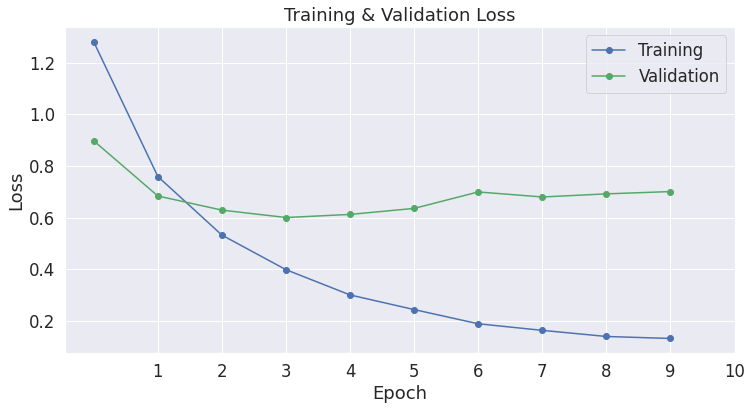

In [ ]:
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12, 6)
df_stats=pd.read_csv('/content/gdrive/My Drive/df_stats_chapo_titre_v7.csv',sep=";")

plt.plot(df_stats["Training Loss"], "b-o", label="Training")
plt.plot(df_stats["Val. Loss"], "g-o", label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([i for i in range(1, epochs + 1)])
plt.show()


(tensor([[-0.7641,  3.0889, -0.6434, -0.6899, -0.7300],
        [ 0.1914, -1.0361, -1.1361,  2.5567, -0.9318],
        [-0.7138, -0.7130,  2.8959, -0.7236, -0.1934],
        ...,
        [-0.5552, -0.8071, -0.8663,  2.7594, -0.9090],
        [-0.5503, -0.7243, -0.9357,  2.7320, -0.9058],
        [ 2.9601, -0.8199, -0.6931, -0.8236, -0.4069]]),)
(tensor([[-0.7641,  3.0889, -0.6434, -0.6899, -0.7300],
        [ 0.1914, -1.0361, -1.1361,  2.5567, -0.9318],
        [-0.7138, -0.7130,  2.8959, -0.7236, -0.1934],
        ...,
        [-0.5552, -0.8071, -0.8663,  2.7594, -0.9090],
        [-0.5503, -0.7243, -0.9357,  2.7320, -0.9058],
        [ 2.9601, -0.8199, -0.6931, -0.8236, -0.4069]]),)
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       189
           1       0.86      0.90      0.88       191
           2       0.79      0.81      0.80       213
           3       0.84      0.75      0.79       204
           4       0.81      0.75  

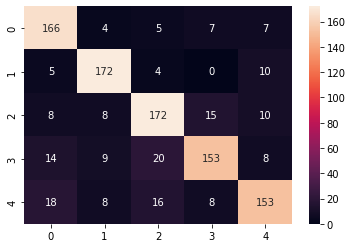

In [ ]:
# Evaluation with the confusion matrix
import seaborn

confusion_matrix = evaluate(reviews_validation, sentiments_validation , 'matrix')
report = evaluate(reviews_validation, sentiments_validation , 'report')
print(report)
seaborn.heatmap(confusion_matrix ,annot=True, fmt="d")




In [26]:
predict(["Obama réunit les responsables des services de renseignement. Barack Obama réunira mardi 5 janvier les responsables des services de renseignement après avoir pointé les carences 'inacceptables' qui ont permis à Al-Qaida de commettre un attentat contre un avion de ligne américain le 25 décembre."])

(tensor([[ 2.9063, -1.0906, -0.9520, -0.5690, -0.1826]]),)


tensor([0])

In [27]:
predict(["Le CAC 40 dépasse les 4 000 points pour la première fois depuis 2008.Après avoir gagné plus de 22 % en 2009, la Bourse de Paris témoigne de sa confiance en ce début d'année."])

(tensor([[-0.7240, -0.6852,  2.8429, -0.5736, -0.3194]]),)


tensor([2])

In [29]:
predict(["Emmanuel Macron choisit Laure de la Raudière pour diriger l’Arcep. Emmanuel Macron a désigné la députée de 55 ans pour diriger le « gendarme » français des télécoms. Un profil plus politique que celui de ses prédécesseurs."])

(tensor([[-0.9595, -0.9672,  2.7919, -0.7838,  0.4365]]),)


tensor([2])

In [30]:
predict(["Les salaires des patrons de la French Tech en forte hausse.Ils auraient progressé de 30% depuis 2019 en raison d'un effet de rattrapage selon une étude. Le salaire annuel brut médian des fondateurs s'élèverait 120.000 euros."])

(tensor([[-0.8118, -0.6589,  2.8837, -0.5554, -0.3120]]),)


tensor([2])

In [31]:
predict(['«Emmerder» les non-vaccinés : Emmanuel Macron dit «assumer totalement» ses propos controversés.Dans une interview au Parisien, le président de la République avait sévèrement chargé les cinq millions de Français qui refusaient de recevoir une injection contre le Covid-19. Des individus à qui il niait le statut de «citoyens».'])

(tensor([[-0.4324, -1.2224, -1.1098,  0.3800,  2.1396]]),)


tensor([4])

In [33]:
predict(["Un outil pour mesurer l’impact environnemental du numérique. FIGARO DEMAIN - Voulue par l’Ademe, la base de données NegaOctet permettra aux entreprises d’évaluer leur bilan écologique."])

(tensor([[-1.4138, -0.8704,  0.4389,  2.4906, -0.7928]]),)


tensor([3])